Курсовой проект для курса "Python для Data Science"

Выполнил Шубин Андрей Сергеевич

Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

Целевая переменная:
Price

Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Требования к решению:
1. R2 > 0.6
2. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
3. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv 
Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).


Загружаем необходимые модули:

In [3914]:
import numpy as np
import pandas as pd
import pickle
import random

from scipy.spatial.distance import cdist
from scipy import stats
from mpl_toolkits.mplot3d.axes3d import Axes3D

from sklearn.preprocessing import StandardScaler, RobustScaler

# Кластеризация
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

from sklearn.neighbors import KNeighborsClassifier

# Понижения размерности
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Загружаем заранее подготовленные функции

In [3915]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3916]:
def emissions_del(signs):
    """Удаление выбросов"""
    max_value = train_df[signs].agg('std') * 3 + train_df[signs].agg('mean')
    print(max_value)
    if train_df[signs].agg('median') == 0:
        my_mm = round(train_df[signs].agg('mean'))
        train_df.loc[train_df[signs] > max_value, [signs]] = my_mm
        test_df.loc[test_df[signs] > max_value, [signs]] = my_mm
    else:
        my_mm = round(train_df[signs].agg('median'))
        train_df.loc[train_df[signs] > max_value, [signs]] = my_mm
        test_df.loc[test_df[signs] > max_value, [signs]] = my_mm
    train_df[signs].fillna(my_mm, inplace = True)
    test_df[signs].fillna(my_mm, inplace = True)

In [3917]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """
    # дописать документация
    """
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))

    plt.figure(figsize=(18,10))
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

Загружаем данные


In [3918]:
train_df = pd.read_csv("D:/train.csv")
train_df.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [3919]:
test_df = pd.read_csv("D:/test.csv")
test_df.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [3920]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [3921]:
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


EDA

1 Исследуем проблему, а именно как образуется целевая переменная и что на нее сильнн всего влияет по моему мнению


Описание датасета:

Id - идентификационный номер квартиры

DistrictId - идентификационный номер района

Rooms - количество комнат

Square - площадь

LifeSquare - жилая площадь

KitchenSquare - площадь кухни

Floor - этаж

HouseFloor - количество этажей в доме

HouseYear - год постройки дома

Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности

Social_1, Social_2, Social_3 - социальные показатели местности

Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья

Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров

Price - цена квартиры

Из колличественных переменных по моему мнению наиболее важные : LifeSquare, HouseYear. А из категориальных признаков переменных DistrictId,
Shops, DistrictId, Ecology.    

Теперь необходимо происследовать целевую переменную

In [3922]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [3923]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   int16   
 1   DistrictId     5000 non-null   int16   
 2   Rooms          5000 non-null   float32 
 3   Square         5000 non-null   float32 
 4   LifeSquare     3959 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   int8    
 7   HouseFloor     5000 non-null   float32 
 8   HouseYear      5000 non-null   int16   
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   int8    
 13  Social_2       5000 non-null   int16   
 14  Social_3       5000 non-null   int16   
 15  Healthcare_1   2623 non-null   float32 
 16  Helthcare_2    5000 non-null   int8    
 17  Shops_1        5000 non-null   in

колличественные признаки

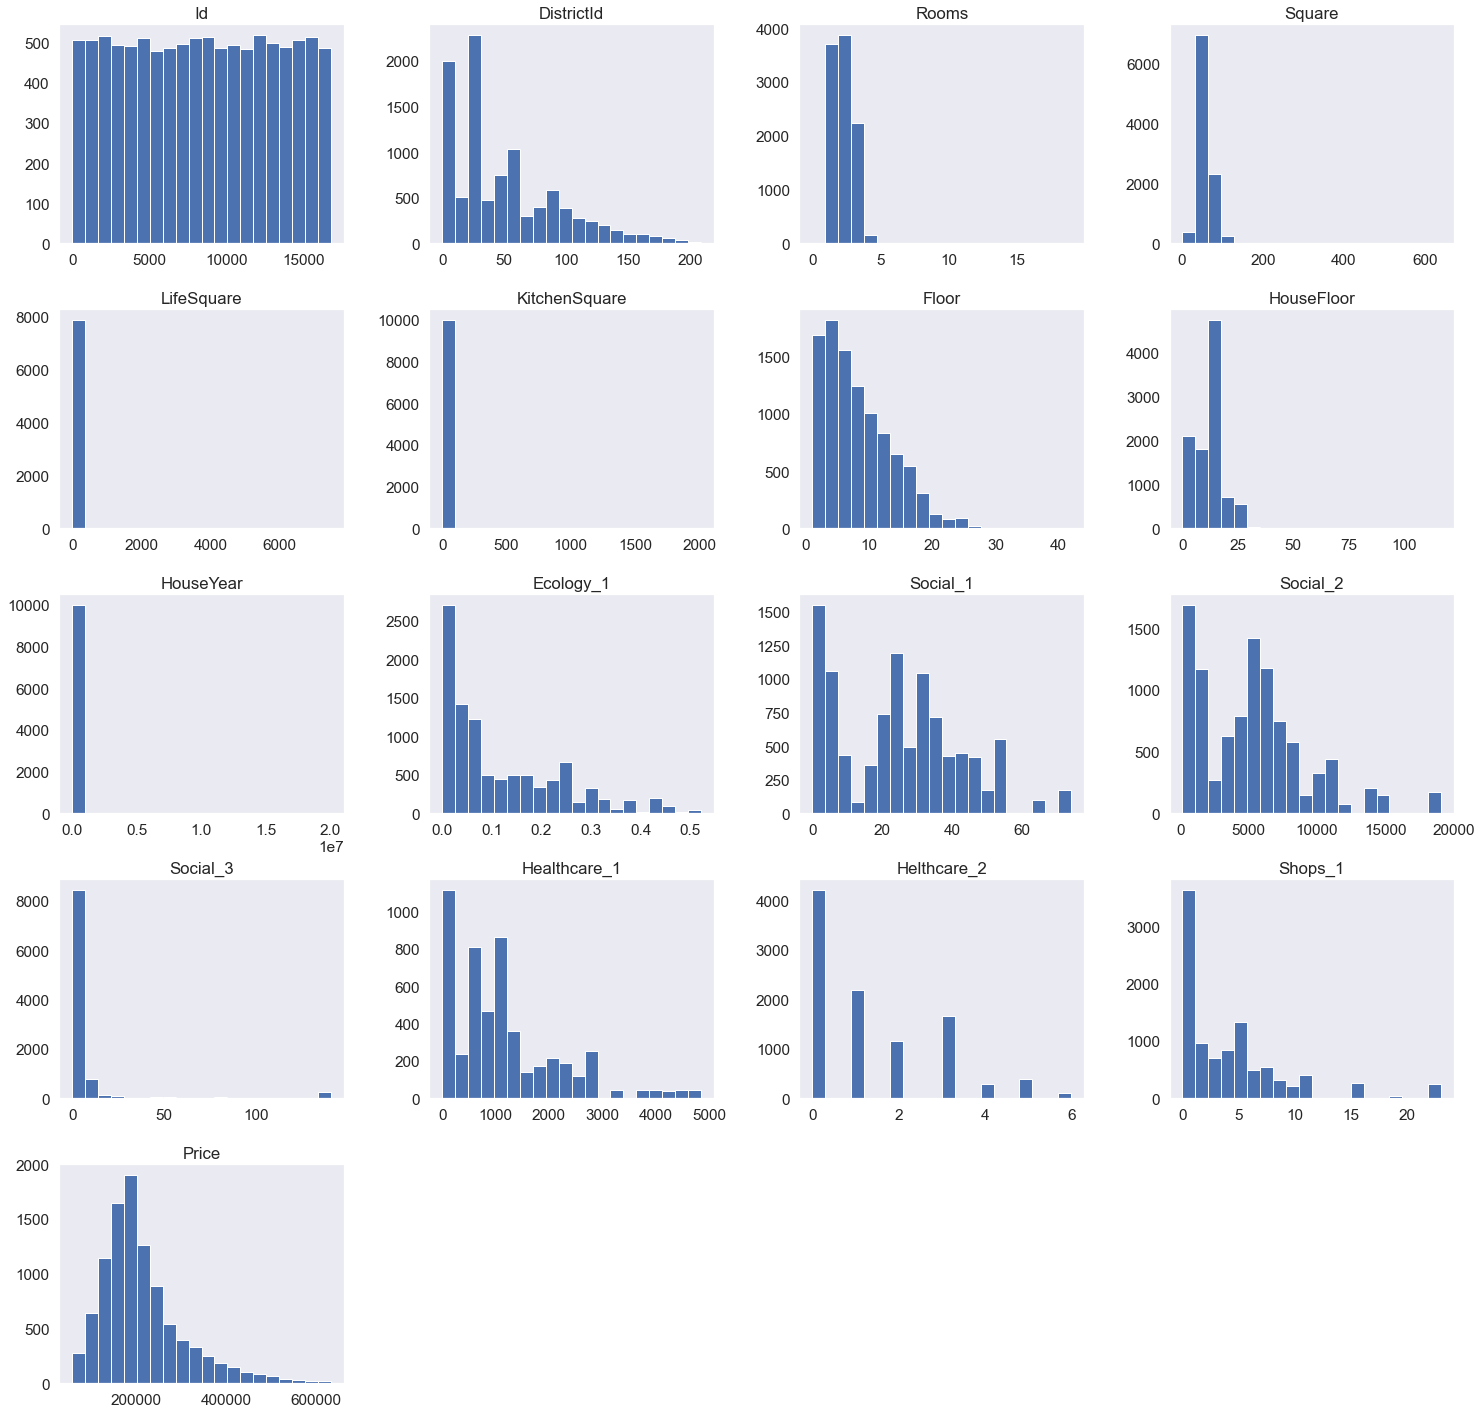

In [3924]:
train_df.hist(figsize=(25,25), bins=20, grid=False);

Категориальные признаки

In [3925]:
cat_colnames = train_df.select_dtypes(include='category').columns.tolist()
cat_colnames

['Ecology_2', 'Ecology_3', 'Shops_2']

In [3926]:
for cat_colname in cat_colnames[2:]:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Shops_2

B    9175
A     825
Name: Shops_2, dtype: int64
****************************************************************************************************



In [3927]:
target_mean = round(train_df.Price.mean(), 2)
target_median = train_df.Price.median()
target_mode = train_df.Price.mode()[0]


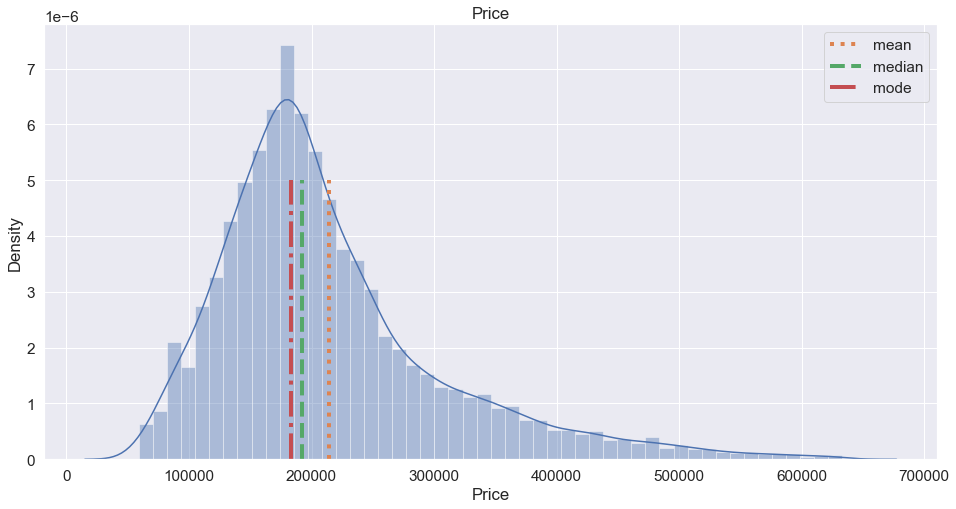

In [3928]:
plt.figure(figsize = (16, 8))

sns.distplot(train_df.Price, bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Price')
plt.legend()
plt.show()

Очень странно ведет себя мода, надо разбиратся

In [3929]:
train_df.Price.mode()[0]

182938.08

In [3930]:
train_df.Price.value_counts()

298194.500000    2
204576.421875    2
182938.078125    2
238608.656250    2
200309.000000    1
                ..
148657.625000    1
191668.406250    1
566435.125000    1
96245.515625     1
559215.437500    1
Name: Price, Length: 9996, dtype: int64

Всех значений по 1й штуке, следоватьльно мода не информативна для работы с целевой переменной

In [3931]:
train_df.Price.describe()

count     10000.000000
mean     214139.218750
std       92872.304688
min       59174.777344
25%      153872.628906
50%      192269.648438
75%      249135.460938
max      633233.437500
Name: Price, dtype: float64

Максимальное значения сильно выходят за рамки, необходимо проверить

In [3932]:
train_df[train_df.Price > 500000].count()

Id               153
DistrictId       153
Rooms            153
Square           153
LifeSquare       137
KitchenSquare    153
Floor            153
HouseFloor       153
HouseYear        153
Ecology_1        153
Ecology_2        153
Ecology_3        153
Social_1         153
Social_2         153
Social_3         153
Healthcare_1     118
Helthcare_2      153
Shops_1          153
Shops_2          153
Price            153
dtype: int64

In [3933]:
print("Skewness: %f" % train_df['Price'].skew())
print("Kurtosis: %f" % train_df['Price'].kurt())

Skewness: 1.366877
Kurtosis: 2.249410


Данные значения скорее всего относятся к престижным районам. Следоватьльно придется разбивать задачу на кластеры для повышения качества модели

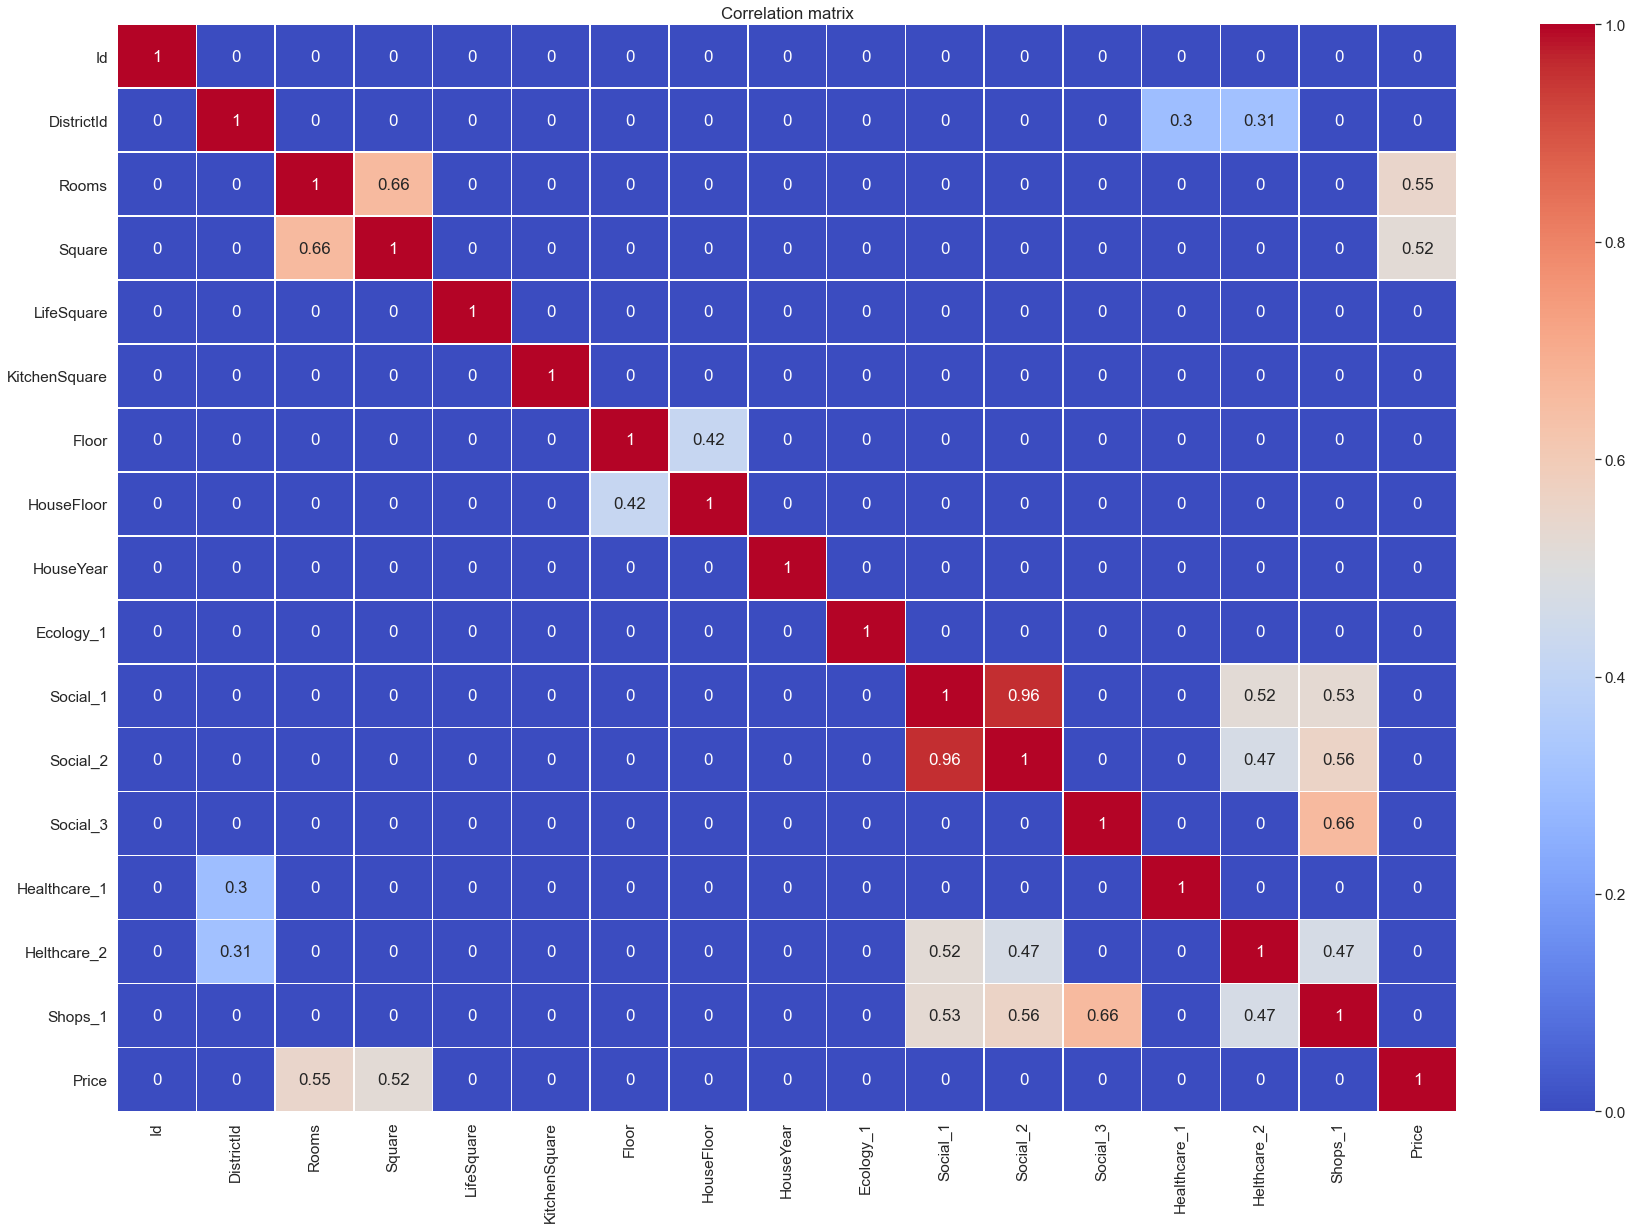

In [3934]:
plt.figure(figsize = (30,20))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Начинаем понемногу исследовать признаки и устранять явные ошибки в данных

0 DistrictId 

In [3935]:
vc = train_df['DistrictId'].value_counts()
vc.tail(15)

193    3
201    3
208    2
186    2
202    2
195    2
172    2
158    2
174    1
209    1
196    1
117    1
205    1
199    1
207    1
Name: DistrictId, dtype: int64

In [3936]:
repeated = set(vc[vc < 10].index.values)

In [3937]:
train_df.loc[train_df['DistrictId'].isin(repeated), 'DistrictId'] = 510

In [3938]:
repeated = train_df['DistrictId'].values
repeated = set(repited)

In [3939]:
test_df.loc[~test_df['DistrictId'].isin(repeated), 'DistrictId'] = 510

In [3940]:
test_df['DistrictId'].isin(repeated)

0       True
1       True
2       True
3       True
4       True
        ... 
4995    True
4996    True
4997    True
4998    True
4999    True
Name: DistrictId, Length: 5000, dtype: bool

No handles with labels found to put in legend.


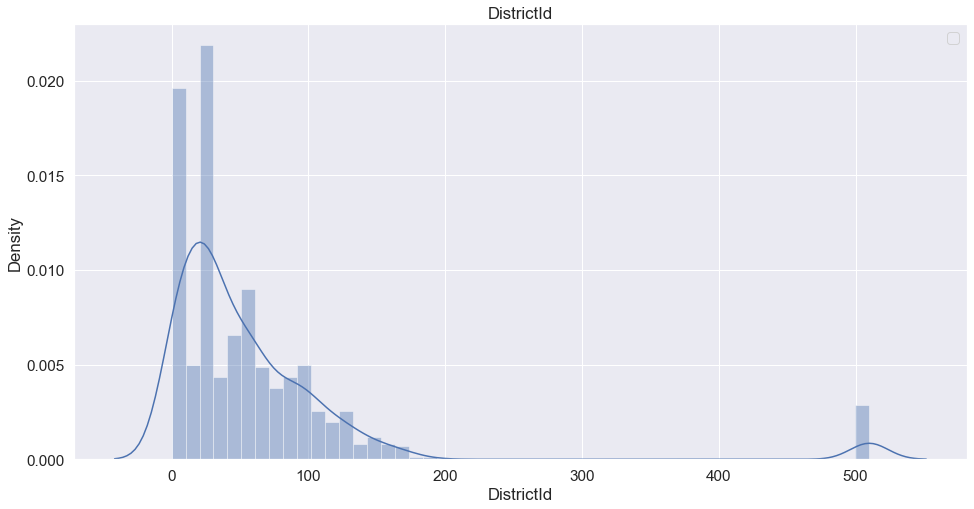

In [3941]:
plt.figure(figsize = (16, 8))

sns.distplot(train_df.DistrictId, bins=50)

y = np.linspace(0, 0.000005, 10)
plt.title('DistrictId')
plt.legend()
plt.show()

Здесь до нормального распределения далеко, данный признак является категориальным

<AxesSubplot:xlabel='DistrictId', ylabel='Price'>

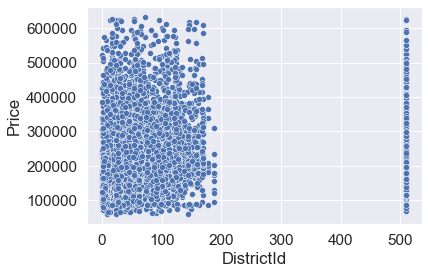

In [3942]:
sns.scatterplot(train_df.DistrictId, train_df.Price)

In [3943]:
train_df['DistrictId']  = train_df['DistrictId'].astype('category')
test_df['DistrictId']  = test_df['DistrictId'].astype('category')

In [3944]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
510    295
      ... 
72      10
106     10
177     10
187     10
156     10
Name: DistrictId, Length: 145, dtype: int64

In [3945]:
test_df.loc[~test_df['DistrictId'].isin(repited), 'DistrictId']

Series([], Name: DistrictId, dtype: category
Categories (145, int64): [0, 1, 2, 3, ..., 170, 177, 187, 510])

In [3946]:
test_df['DistrictId'].value_counts()

27     391
1      344
23     264
6      257
510    164
      ... 
40       3
142      3
36       2
154      2
150      1
Name: DistrictId, Length: 145, dtype: int64

In [3947]:
med_price_by_district = train_df.groupby(['DistrictId'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByDistrict'})

#med_price_by_district = med_price_by_district['Price'].median()

med_price_by_district.head(10)

,DistrictId,MedPriceByDistrict
0,0,165963.062500
1,1,183663.437500
2,2,208539.500000
3,3,169094.015625
4,4,278639.468750
5,5,238902.093750
6,6,168980.375000
7,7,211019.250000
8,8,189439.609375
9,9,186307.765625


In [3948]:
test_df = test_df.merge(med_price_by_district, on=['DistrictId'], how='left')
train_df = train_df.merge(med_price_by_district, on=['DistrictId'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByDistrict
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,...,B,33,7976,5,NaN,0,11,B,184966.937500,203602.406250
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,...,B,46,10309,1,240.0,1,16,B,300009.437500,210694.843750
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,...,B,34,7759,0,229.0,1,3,B,220925.906250,245978.796875
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,...,B,23,5735,3,1084.0,0,5,B,175616.234375,151557.906250
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,...,B,35,5776,1,2078.0,2,4,B,150226.531250,178829.171875


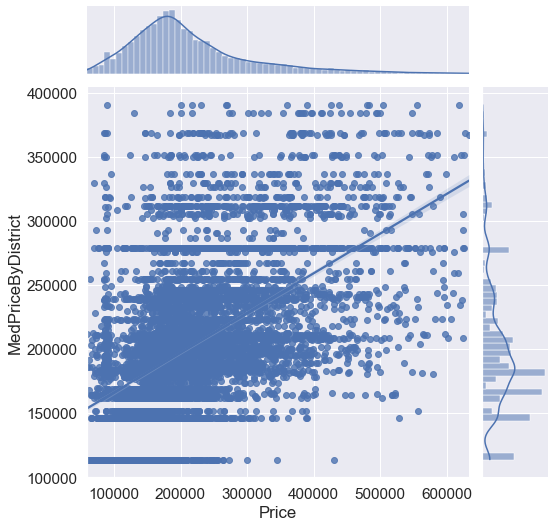

In [3949]:
signs = 'MedPriceByDistrict'
grid = sns.jointplot(train_df['Price'], train_df.loc[train_df[signs] > 0, signs], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

матрица корриляции показала, что значимыми колличественными признаками являются колличество комнат и площадь

удаляем явные выбросы.

In [3950]:
my_1_1 = train_df['Square'].quantile(.995)
my_1_2 = train_df['Square'].quantile(.01)

my_2_1 = train_df['LifeSquare'].quantile(.99)
my_2_2 = train_df['LifeSquare'].quantile(.01)

my_3_1 = train_df['KitchenSquare'].quantile(.99)
my_3_2 = train_df['KitchenSquare'].quantile(.01)

In [3951]:
my_1_1

132.82090370178219

In [3952]:
my_median1 = train_df['Square'].median()
my_median2 = train_df['LifeSquare'].median()
my_median3 = train_df['KitchenSquare'].median()

In [3953]:
train_df.loc[(train_df['Square'] > my_1_1) | (train_df['Square'] < my_1_2), 'Square'] = my_median1

train_df.loc[(train_df['LifeSquare'] > my_2_1) | (train_df['Square'] < my_2_2), 'LifeSquare'] = my_median2

train_df.loc[(train_df['KitchenSquare'] > my_3_1) | (train_df['Square'] < my_3_2), 'KitchenSquare'] = my_median3
         

In [3954]:
test_df.loc[(test_df['Square'] > my_1_1) | (test_df['Square'] < my_1_2), 'Square'] = my_median1

test_df.loc[(test_df['LifeSquare'] > my_2_1) | (test_df['Square'] < my_2_2), 'LifeSquare'] = my_median2

test_df.loc[(test_df['KitchenSquare'] > my_3_1) | (test_df['Square'] < my_3_2), 'KitchenSquare'] = my_median3
         

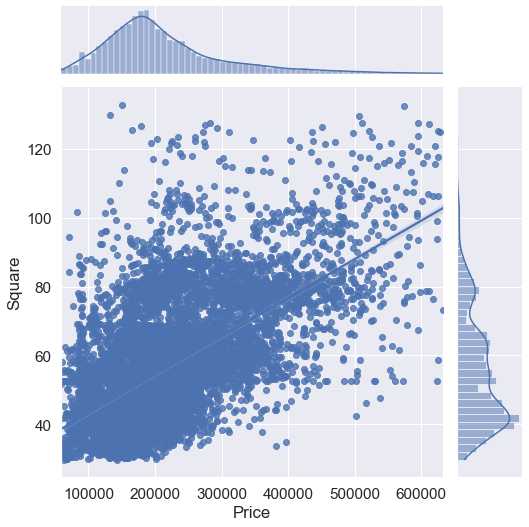

In [3955]:
signs = 'Square'
grid = sns.jointplot(train_df['Price'], train_df.loc[train_df[signs] > 0, signs], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

Комнаты. вообще странно, что число комнат представлено дробным числом

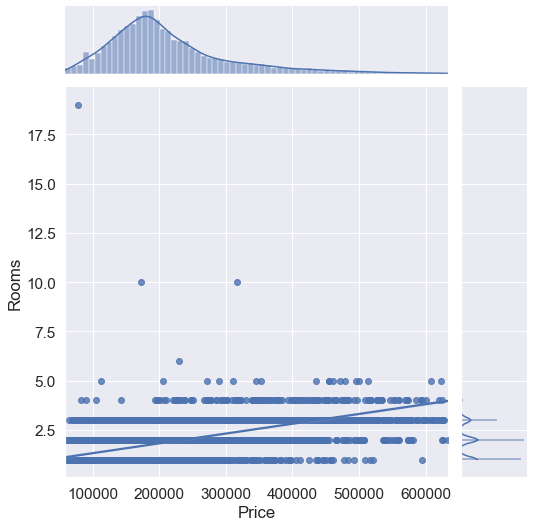

In [3956]:
signs = 'Rooms'
grid = sns.jointplot(train_df['Price'], train_df.loc[train_df[signs] > 0, signs], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

In [3957]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

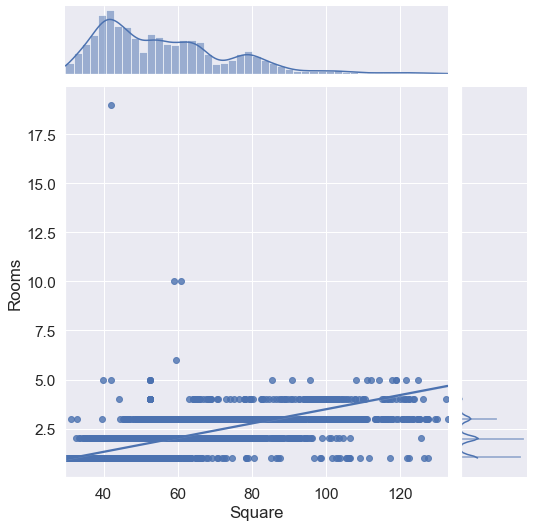

In [3958]:
signs = 'Rooms'
grid = sns.jointplot(train_df['Square'], train_df.loc[train_df[signs] > 0, signs], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

In [3959]:
train_df.loc[train_df['Rooms'] > 9 ]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByDistrict
377,5927,57,10.0,59.056976,36.223072,10.0,22,22.0,2002,0.090799,...,B,74,19083,2,NaN,5,15,B,317265.312500,200291.734375
1454,8491,1,19.0,42.006046,21.779287,7.0,17,17.0,2014,0.007122,...,B,1,264,0,NaN,0,1,B,78364.617188,183663.437500
8849,14865,9,10.0,60.871265,38.420681,10.0,3,2.0,1994,0.161532,...,B,25,5648,1,30.0,2,4,B,172329.265625,186307.765625


In [3960]:
test_df['Rooms'].value_counts()

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
0.0        2
6.0        2
17.0       1
Name: Rooms, dtype: int64

In [3961]:
test_df.loc[test_df['Rooms'] > 9 ]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,MedPriceByDistrict
3398,1435,111,17.0,52.866108,32.528343,8.0,15,17.0,1987,0.093443,B,B,23,4635,5,3300.0,2,4,B,243040.140625


19 комнат на такой мальенькой площади вряд ли подойдут даже для собак

In [3962]:
my_median = int(train_df['Rooms'].median())
train_df.loc[train_df['Rooms'].isin([0, 10, 19]), 'Rooms'] = my_median
test_df.loc[test_df['Rooms'].isin([0, 17]), 'Rooms'] = my_median

In [3963]:
train_df['Rooms']  = train_df['Rooms'].astype('int8')
test_df['Rooms']  = test_df['Rooms'].astype('int8')

3   LifeSquare 

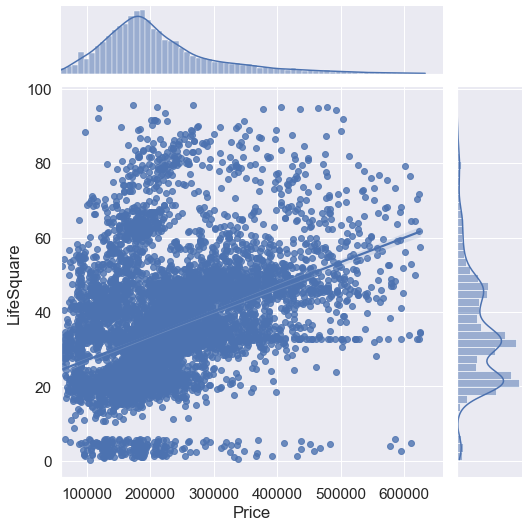

In [3964]:
signs = 'LifeSquare'
grid = sns.jointplot(train_df['Price'], train_df.loc[train_df[signs] > 0, signs], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

In [3965]:
train_df['LifeSquare'].describe()

count    7887.000000
mean       35.243183
std        15.688211
min         0.370619
25%        22.769833
50%        32.781261
75%        44.645790
max        95.645828
Name: LifeSquare, dtype: float64

In [3966]:
mask = train_df["Square"] < train_df["KitchenSquare"] + train_df["LifeSquare"]
train_df.loc[mask].describe()

,Id,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,MedPriceByDistrict
count,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,284.000000,763.000000,763.000000,763.000000,763.000000
mean,8267.952818,1.723460,55.519619,56.045002,4.486238,9.943644,14.525557,2000.598952,0.107653,16.038008,3684.263434,8.420708,880.151428,0.863696,3.411533,195296.484375,189228.437500
std,4898.219115,0.785908,15.927304,16.225121,4.346934,5.938948,8.589065,19.643585,0.111414,16.922081,3925.804375,28.140022,700.006714,1.343705,5.171695,90962.109375,56515.222656
min,10.000000,1.000000,29.719934,22.892380,0.000000,1.000000,0.000000,1918.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,59877.593750,113789.562500
25%,3918.000000,1.000000,41.715078,41.832167,1.000000,5.000000,9.000000,1977.000000,0.011654,2.000000,629.000000,0.000000,540.000000,0.000000,0.000000,133001.117188,146171.437500
50%,8143.000000,2.000000,52.513309,53.491302,1.000000,9.000000,17.000000,2015.000000,0.072158,6.000000,1564.000000,1.000000,705.000000,0.000000,1.000000,174696.406250,168980.375000
75%,12425.500000,2.000000,65.761917,66.599480,10.000000,14.000000,17.000000,2017.000000,0.195781,26.000000,6139.000000,4.000000,1046.000000,1.000000,5.000000,232716.609375,210597.859375
max,16781.000000,5.000000,101.528442,95.489517,15.000000,28.000000,117.000000,2020.000000,0.486246,74.000000,19083.000000,141.000000,4508.000000,6.000000,23.000000,573539.687500,384122.781250


убираем выбросы по нижней границе

In [3967]:
train_df.loc[train_df['LifeSquare'] < 10, 'LifeSquare'] = 10
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [3968]:
test_df.loc[test_df['LifeSquare'] < 10, 'LifeSquare'].sum()

376.35376

In [3969]:
test_df.loc[test_df['KitchenSquare'] < 3, 'KitchenSquare'].sum()

1199.0

In [3970]:
test_df.loc[test_df['LifeSquare'] < 10, 'LifeSquare'] = 10
test_df.loc[test_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [3971]:
square_med_diff = (train_df.loc[train_df['LifeSquare'].notnull(), 'Square'] -\
                   train_df.loc[train_df['LifeSquare'].notnull(), 'LifeSquare'] -\
                   train_df.loc[train_df['LifeSquare'].notnull(), 'KitchenSquare']).median()

square_med_diff

11.593353271484375

In [3972]:
#mask = train_df["Square"] < train_df["KitchenSquare"] + train_df["LifeSquare"]
train_df.loc[mask, 'Square'] = train_df["KitchenSquare"] + train_df["LifeSquare"] + square_med_diff
train_df.loc[mask]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByDistrict
3,5809,58,2,73.324860,52.731510,9.0,8,17.0,1977,0.437885,...,B,23,5735,3,1084.0,0,5,B,175616.234375,151557.90625
28,8054,23,1,58.561111,43.967758,3.0,3,9.0,2014,0.034656,...,B,0,168,0,NaN,0,0,B,95338.195312,113789.56250
48,7596,23,1,70.401344,46.807991,12.0,3,9.0,1977,0.014073,...,B,2,475,0,NaN,0,0,B,96029.164062,113789.56250
52,2301,1,2,79.817955,65.224602,3.0,17,22.0,2016,0.007122,...,B,1,264,0,NaN,0,1,B,199215.453125,183663.43750
69,6925,27,2,84.897957,63.304604,10.0,15,17.0,2016,0.072158,...,B,2,629,1,NaN,0,0,A,228584.000000,146171.43750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9884,41,30,2,83.032440,59.439083,12.0,5,5.0,2016,0.000078,...,B,22,6398,141,1046.0,3,23,B,126281.140625,164259.09375
9889,12918,23,2,70.727600,53.134243,6.0,3,17.0,2017,0.005767,...,B,1,388,0,NaN,0,0,B,88150.015625,113789.56250
9897,4497,1,1,57.603401,38.010048,8.0,7,17.0,1991,0.025609,...,B,33,5261,0,240.0,3,1,B,97464.328125,183663.43750
9902,14001,73,1,58.860905,44.267551,3.0,7,24.0,2014,0.042032,...,B,37,6856,84,1940.0,2,5,B,381937.406250,367188.50000


есть зависимость стоимости от жилой площади, но все портят выбросы. Так же значения представленные NaN и малой жилой площадью скорее всего обозначают магазины итд. Их надо исследовать отдельно.

In [3973]:
my_df = train_df[train_df['LifeSquare'].isna()]
my_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByDistrict
7,11993,74,2,80.312927,NaN,3.0,14,0.0,1977,0.075779,...,B,6,1437,3,NaN,0,2,B,221244.156250,195610.96875
8,5172,1,2,64.511436,NaN,3.0,9,17.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,229102.796875,183663.43750
21,11935,27,2,64.711838,NaN,3.0,15,1.0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,127200.023438,146171.43750
23,6641,54,3,118.907608,NaN,3.0,2,0.0,1977,0.006076,...,B,30,5285,0,645.0,6,6,B,571069.062500,351112.00000
25,5073,74,2,82.667915,NaN,3.0,16,17.0,1977,0.075779,...,B,6,1437,3,NaN,0,2,B,244145.828125,195610.96875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,16159,27,1,38.968338,NaN,3.0,10,1.0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,95529.570312,146171.43750
9986,2996,1,2,64.994247,NaN,3.0,9,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,200332.515625,183663.43750
9987,15623,23,2,55.620090,NaN,3.0,2,4.0,1977,0.034656,...,B,0,168,0,NaN,0,0,B,115797.554688,113789.56250
9994,4158,23,2,64.864197,NaN,3.0,17,17.0,1977,0.075779,...,B,6,1437,3,NaN,0,2,B,171323.515625,113789.56250


In [3974]:
my_df.describe()

,Id,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,MedPriceByDistrict
count,2113.000000,2113.000000,2113.000000,0.0,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,745.000000,2113.000000,2113.000000,2113.000000,2113.000000
mean,8256.636062,1.781827,59.414993,NaN,3.451018,9.913393,13.248935,1981.707525,0.105183,10.528159,2569.010885,10.899195,733.229553,0.565547,3.111690,179534.000000,170688.890625
std,4835.706043,0.761410,17.433868,NaN,1.780481,5.563304,8.091370,12.690541,0.113982,12.871756,3021.569733,35.099679,513.620178,1.117011,5.872527,75178.484375,43558.914062
min,28.000000,1.000000,29.833612,NaN,3.000000,1.000000,0.000000,1977.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,60502.582031,113789.562500
25%,3917.000000,1.000000,43.899937,NaN,3.000000,5.000000,4.000000,1977.000000,0.007122,2.000000,469.000000,0.000000,540.000000,0.000000,0.000000,130409.468750,146171.437500
50%,8308.000000,2.000000,58.027966,NaN,3.000000,9.000000,17.000000,1977.000000,0.072158,5.000000,1437.000000,0.000000,540.000000,0.000000,1.000000,167088.406250,168980.375000
75%,12357.000000,2.000000,68.053230,NaN,3.000000,14.000000,17.000000,1977.000000,0.197368,22.000000,5212.000000,3.000000,1046.000000,0.000000,2.000000,205482.593750,183663.437500
max,16777.000000,5.000000,129.475021,NaN,15.000000,27.000000,30.000000,2019.000000,0.437885,53.000000,14892.000000,141.000000,4702.000000,6.000000,23.000000,633233.437500,368177.500000


In [3975]:
test_df[test_df['LifeSquare'].isna()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,MedPriceByDistrict
1,15856,74,2,69.263184,NaN,3.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,195610.968750
5,7633,53,1,40.675625,NaN,3.0,21,21.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B,245978.796875
11,3310,6,3,84.625351,NaN,3.0,6,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,168980.375000
14,5214,27,1,37.555195,NaN,3.0,5,1.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,146171.437500
21,16688,1,1,44.878765,NaN,3.0,1,9.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,183663.437500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,4723,95,1,45.542938,NaN,3.0,6,0.0,1977,0.000699,B,B,14,3369,24,4129.0,0,3,B,293249.093750
4985,11732,1,1,46.597282,NaN,3.0,17,24.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,183663.437500
4987,5361,53,3,80.102104,NaN,3.0,13,22.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B,245978.796875
4998,4780,62,2,81.305222,NaN,3.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,162067.281250


In [3976]:
test_1cat = test_df[test_df['LifeSquare'].isna()]
train_1cat = test_df[test_df['LifeSquare'].isna()]
train_1cat

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,MedPriceByDistrict
1,15856,74,2,69.263184,NaN,3.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,195610.968750
5,7633,53,1,40.675625,NaN,3.0,21,21.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B,245978.796875
11,3310,6,3,84.625351,NaN,3.0,6,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,168980.375000
14,5214,27,1,37.555195,NaN,3.0,5,1.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,146171.437500
21,16688,1,1,44.878765,NaN,3.0,1,9.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,183663.437500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,4723,95,1,45.542938,NaN,3.0,6,0.0,1977,0.000699,B,B,14,3369,24,4129.0,0,3,B,293249.093750
4985,11732,1,1,46.597282,NaN,3.0,17,24.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,183663.437500
4987,5361,53,3,80.102104,NaN,3.0,13,22.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B,245978.796875
4998,4780,62,2,81.305222,NaN,3.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,162067.281250


In [3977]:
test_cat = test_df[~test_df['LifeSquare'].isna()]
train_cat = test_df[~test_df['LifeSquare'].isna()]
train_1cat

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,MedPriceByDistrict
1,15856,74,2,69.263184,NaN,3.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,195610.968750
5,7633,53,1,40.675625,NaN,3.0,21,21.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B,245978.796875
11,3310,6,3,84.625351,NaN,3.0,6,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,168980.375000
14,5214,27,1,37.555195,NaN,3.0,5,1.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,146171.437500
21,16688,1,1,44.878765,NaN,3.0,1,9.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,183663.437500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,4723,95,1,45.542938,NaN,3.0,6,0.0,1977,0.000699,B,B,14,3369,24,4129.0,0,3,B,293249.093750
4985,11732,1,1,46.597282,NaN,3.0,17,24.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,183663.437500
4987,5361,53,3,80.102104,NaN,3.0,13,22.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B,245978.796875
4998,4780,62,2,81.305222,NaN,3.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,162067.281250


In [3978]:
train_df['Claster1'] = 0
test_df['Claster1'] = 0

In [3979]:
train_df.loc[train_df['LifeSquare'].isnull(), 'Claster1'] = 1
test_df.loc[test_df['LifeSquare'].isnull(), 'Claster1'] = 1

In [3980]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] =\
train_df.loc[train_df['LifeSquare'].isnull(), 'Square'] -\
train_df.loc[train_df['LifeSquare'].isnull(), 'KitchenSquare'] -\
square_med_diff

In [3981]:
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] =\
test_df.loc[test_df['LifeSquare'].isnull(), 'Square'] -\
test_df.loc[test_df['LifeSquare'].isnull(), 'KitchenSquare'] -\
square_med_diff

Исследуем второй признак с пропусками

14  Healthcare_1

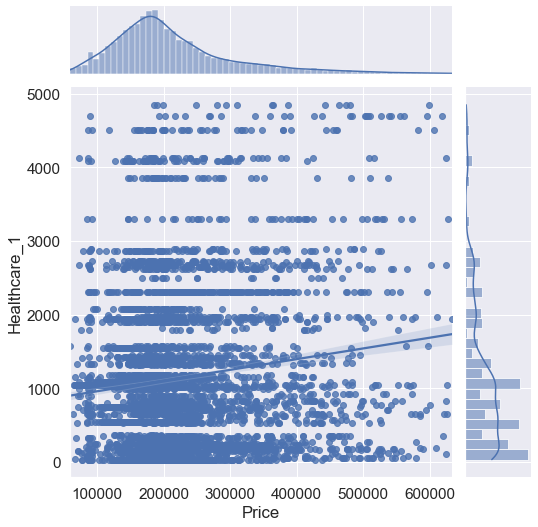

In [3982]:
signs = 'Healthcare_1'
grid = sns.jointplot(train_df['Price'], train_df.loc[train_df[signs] > 0, signs], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

In [3983]:
train_df['Healthcare_1'].describe()

count    5202.000000
mean     1142.904419
std      1021.518982
min         0.000000
25%       350.000000
50%       900.000000
75%      1548.000000
max      4849.000000
Name: Healthcare_1, dtype: float64

In [3984]:
my_median = int(train_df['Healthcare_1'].median())

In [3985]:
train_df['Healthcare_1'].fillna(my_median, inplace=True)
test_df['Healthcare_1'].fillna(my_median, inplace=True)

KitchenSquare - площадь кухни

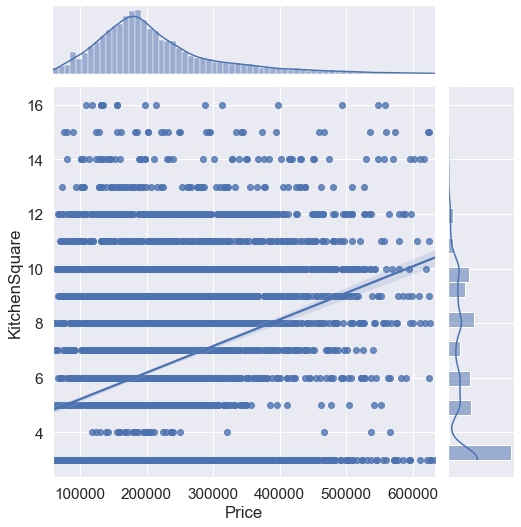

In [3986]:
signs = 'KitchenSquare'
grid = sns.jointplot(train_df['Price'], train_df.loc[train_df[signs] > 0, signs], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

Floor и HouseFloor

In [3987]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.],
      dtype=float32)

In [3988]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

In [3989]:
my_median = int(train_df['HouseFloor'].median())
my_median

13

In [3990]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = my_median

In [3991]:
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = my_median

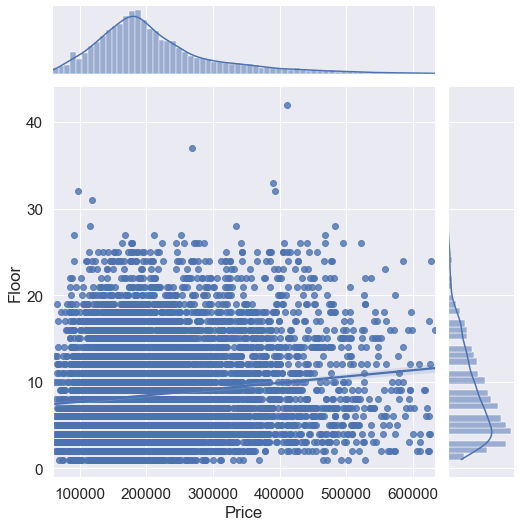

In [3992]:
signs = 'Floor'
grid = sns.jointplot(train_df['Price'], train_df.loc[train_df[signs] > 0, signs], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

In [3993]:
np.random.seed(27)
floor_outliers = train_df[train_df['Floor'] > train_df['HouseFloor']].index
print(len(floor_outliers))

train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(
    lambda x: random.randint(1, x)
)

1610


год постройки

In [3994]:
train_df['HouseYear'] = train_df['HouseYear'] // 10 * 10
test_df['HouseYear'] = test_df['HouseYear'] // 10 * 10

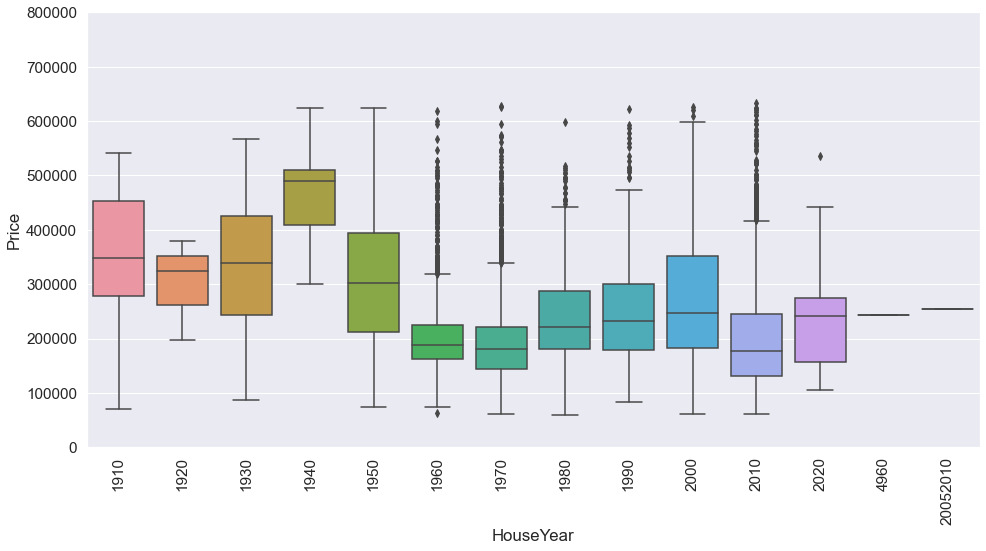

In [3995]:
var = 'HouseYear'
data = pd.concat([train_df['Price'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="Price", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

тут мы можем наблюдать выбросы, так как я сомневаюсь в том что 4960год уже прошел. К тому же мне кажется что это категориальный признак

In [3996]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020 #train_df['HouseYear'].median()

In [3997]:
test_df.loc[test_df['HouseYear'] > 2020, 'HouseYear'].count()

0

In [3998]:
test_df.loc[test_df['HouseYear'] < 1910, 'HouseYear'].count()

2

In [3999]:
test_df.loc[test_df['HouseYear'] < 1910, 'HouseYear'] = 1910

<AxesSubplot:xlabel='HouseYear', ylabel='Count'>

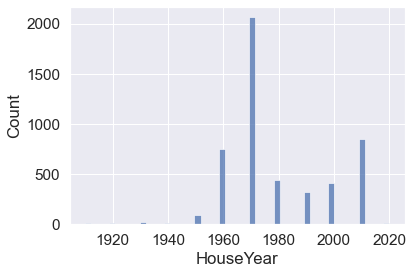

In [4000]:
sns.histplot(test_df.HouseYear, bins=50)

In [4001]:
train_df['HouseYear']  = train_df['HouseYear'].astype('category')
test_df['HouseYear']  = test_df['HouseYear'].astype('category')

In [4002]:
train_df['HouseYear'].value_counts()

1970    4061
2010    1722
1960    1466
1980     886
2000     857
1990     695
1950     215
1930      46
2020      21
1910      16
1940      12
1920       3
Name: HouseYear, dtype: int64

In [4003]:
test_df['HouseYear'].value_counts()

1970    2064
2010     855
1960     754
1980     438
2000     410
1990     324
1950      94
1930      19
1920      14
1910      10
1940       9
2020       9
Name: HouseYear, dtype: int64

Переработаем категориальные признаки

In [4004]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})

In [4005]:
test_df['Ecology_2_bin'] = test_df['Ecology_2'].replace({'A':0, 'B':1})
test_df['Ecology_3_bin'] = test_df['Ecology_3'].replace({'A':0, 'B':1})
test_df['Shops_2_bin'] = test_df['Shops_2'].replace({'A':0, 'B':1})

Экологические категориальные признаки сильно коррелируют друг с другом

In [4006]:
train_df.Ecology_2 = train_df.Ecology_2.astype('str')
train_df.Ecology_3 = train_df.Ecology_3.astype('str')
test_df.Ecology_2 = test_df.Ecology_2.astype('str')
test_df.Ecology_3 = test_df.Ecology_3.astype('str')

In [4007]:
train_df["Eco2_Eco3"] = train_df.Ecology_2 + train_df.Ecology_3
test_df["Eco2_Eco3"] = test_df.Ecology_2 + test_df.Ecology_3
train_df["Eco2_Eco3"]

0       BB
1       BB
2       BB
3       BB
4       BB
        ..
9995    BB
9996    BB
9997    BB
9998    BA
9999    BB
Name: Eco2_Eco3, Length: 10000, dtype: object

In [4008]:
train_df.Ecology_2 = train_df.Ecology_2.astype('category')
train_df.Ecology_3 = train_df.Ecology_3.astype('category')
test_df.Ecology_2 = test_df.Ecology_2.astype('category')
test_df.Ecology_3 = test_df.Ecology_3.astype('category')

train_df.Eco2_Eco3 = train_df.Eco2_Eco3.astype('category')
test_df.Eco2_Eco3 = test_df.Eco2_Eco3.astype('category')

In [4009]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'MedPriceByDistrict',
 'Claster1',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'Eco2_Eco3']

In [4010]:
train_df.drop(['DistrictId', 'Ecology_2', 'Ecology_3'], axis=1, inplace=True)
test_df.drop(['DistrictId', 'Ecology_2', 'Ecology_3'], axis=1, inplace=True)

Исследование модели на предмет кластеризации

In [4011]:
train_df_dm = pd.get_dummies(train_df)
test_df_dm = pd.get_dummies(test_df)

In [4012]:
train_df_dm.drop('Id', axis=1, inplace=True)
test_df_dm.drop('Id', axis=1, inplace=True)

In [4013]:
train_df_dm

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,Ecology_1,Social_1,Social_2,Social_3,...,HouseYear_1980,HouseYear_1990,HouseYear_2000,HouseYear_2010,HouseYear_2020,Shops_2_A,Shops_2_B,Eco2_Eco3_AB,Eco2_Eco3_BA,Eco2_Eco3_BB
0,2,47.981560,29.442751,6.0,7,9.0,0.089040,33,7976,5,...,0,0,0,0,0,0,1,0,0,1
1,3,65.683640,40.049541,8.0,7,9.0,0.000070,46,10309,1,...,0,0,0,0,0,0,1,0,0,1
2,2,44.947952,29.197611,3.0,8,12.0,0.049637,34,7759,0,...,0,0,0,0,0,0,1,0,0,1
3,2,73.324860,52.731510,9.0,8,17.0,0.437885,23,5735,3,...,0,0,0,0,0,0,1,0,0,1
4,1,39.649193,23.776169,7.0,11,12.0,0.012339,35,5776,1,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,50.401787,30.476204,5.0,2,5.0,0.135650,46,7960,6,...,0,0,0,0,0,0,1,0,0,1
9996,1,41.521545,20.539215,9.0,13,13.0,0.000000,30,5562,0,...,0,0,1,0,0,1,0,0,0,1
9997,1,47.939007,33.345654,3.0,12,16.0,0.072158,2,629,1,...,0,0,0,1,0,1,0,0,0,1
9998,2,43.602562,33.840149,8.0,1,5.0,0.307467,30,5048,9,...,0,0,0,0,0,0,1,0,1,0


In [4014]:
X = train_df_dm.drop('Price', axis=1)
y = train_df_dm['Price'].values

X.head(2)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,Ecology_1,Social_1,Social_2,Social_3,...,HouseYear_1980,HouseYear_1990,HouseYear_2000,HouseYear_2010,HouseYear_2020,Shops_2_A,Shops_2_B,Eco2_Eco3_AB,Eco2_Eco3_BA,Eco2_Eco3_BB
0,2,47.98156,29.442751,6.0,7,9.0,0.08904,33,7976,5,...,0,0,0,0,0,0,1,0,0,1
1,3,65.68364,40.049541,8.0,7,9.0,0.00007,46,10309,1,...,0,0,0,0,0,0,1,0,0,1


In [4015]:
train_df_dm.shape

(10000, 36)

In [4016]:
test_df_dm.shape

(5000, 35)

In [4017]:
X.shape

(10000, 35)

In [4018]:
train_df_dm.columns

Index(['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
       'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Price', 'MedPriceByDistrict', 'Claster1',
       'Ecology_2_bin', 'Ecology_3_bin', 'Shops_2_bin', 'HouseYear_1910',
       'HouseYear_1920', 'HouseYear_1930', 'HouseYear_1940', 'HouseYear_1950',
       'HouseYear_1960', 'HouseYear_1970', 'HouseYear_1980', 'HouseYear_1990',
       'HouseYear_2000', 'HouseYear_2010', 'HouseYear_2020', 'Shops_2_A',
       'Shops_2_B', 'Eco2_Eco3_AB', 'Eco2_Eco3_BA', 'Eco2_Eco3_BB'],
      dtype='object')

In [4019]:
test_df_dm.columns

Index(['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
       'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'MedPriceByDistrict', 'Claster1',
       'Ecology_2_bin', 'Ecology_3_bin', 'Shops_2_bin', 'HouseYear_1910',
       'HouseYear_1920', 'HouseYear_1930', 'HouseYear_1940', 'HouseYear_1950',
       'HouseYear_1960', 'HouseYear_1970', 'HouseYear_1980', 'HouseYear_1990',
       'HouseYear_2000', 'HouseYear_2010', 'HouseYear_2020', 'Shops_2_A',
       'Shops_2_B', 'Eco2_Eco3_AB', 'Eco2_Eco3_BA', 'Eco2_Eco3_BB'],
      dtype='object')

In [4020]:
scaler = RobustScaler()

colnames = X.columns
train_df_dm_scaled = pd.DataFrame(scaler.fit_transform(X), columns=colnames)
test_df_dm_scaled = pd.DataFrame(scaler.transform(test_df_dm), columns=colnames)

train_df_dm_scaled.head(2)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,Ecology_1,Social_1,Social_2,Social_3,...,HouseYear_1980,HouseYear_1990,HouseYear_2000,HouseYear_2010,HouseYear_2020,Shops_2_A,Shops_2_B,Eco2_Eco3_AB,Eco2_Eco3_BA,Eco2_Eco3_BB
0,0.0,-0.256030,-0.182867,0.000000,0.125,-0.5,0.076437,0.266667,0.475190,0.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.465172,0.288268,0.333333,0.125,-0.5,-0.423017,0.700000,0.887162,-0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4021]:
#dim_reducer = TSNE(n_components=2, learning_rate=250, random_state=42, perplexity=30)
#train_df_dm_scaled = dim_reducer.fit_transform(train_df_dm_scaled.dropna())       

In [4022]:
#plt.scatter(train_df_dm_scaled[:, 0], train_df_dm_scaled[:, 1])

колличество кластеров по графику t-SNE = 3

Кластеризация

In [4023]:
kmeans_3 = KMeans(n_clusters=3, random_state=42)
labels_clast_3 = kmeans_3.fit_predict(train_df_dm_scaled)
labels_clast_3 = pd.Series(labels_clast_3, name='clusters_3')
labels_clast_3_test = kmeans_3.predict(test_df_dm_scaled)
labels_clast_3_test = pd.Series(labels_clast_3_test, name='clusters_3')

unique, counts = np.unique(labels_clast_3, return_counts=True)

In [4024]:
clusters_3_dummies = pd.get_dummies(labels_clast_3, drop_first=True, prefix='clusters_3')

X_train_cluster = pd.concat([train_df_dm_scaled, clusters_3_dummies], 
                   axis=1)
X_train_cluster.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,Ecology_1,Social_1,Social_2,Social_3,...,HouseYear_2000,HouseYear_2010,HouseYear_2020,Shops_2_A,Shops_2_B,Eco2_Eco3_AB,Eco2_Eco3_BA,Eco2_Eco3_BB,clusters_3_1,clusters_3_2
0,0.0,-0.256030,-0.182867,0.000000,0.125,-0.500,0.076437,0.266667,0.475190,0.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
1,1.0,0.465172,0.288268,0.333333,0.125,-0.500,-0.423017,0.700000,0.887162,-0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
2,0.0,-0.379623,-0.193756,-0.500000,0.250,-0.125,-0.144759,0.300000,0.436871,-0.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
3,0.0,0.776484,0.851579,0.500000,0.250,0.500,2.034769,-0.066667,0.079463,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
4,-1.0,-0.595500,-0.434567,0.166667,0.625,-0.125,-0.354142,0.333333,0.086703,-0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [4025]:
X_train_cluster.columns

Index(['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
       'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'MedPriceByDistrict', 'Claster1',
       'Ecology_2_bin', 'Ecology_3_bin', 'Shops_2_bin', 'HouseYear_1910',
       'HouseYear_1920', 'HouseYear_1930', 'HouseYear_1940', 'HouseYear_1950',
       'HouseYear_1960', 'HouseYear_1970', 'HouseYear_1980', 'HouseYear_1990',
       'HouseYear_2000', 'HouseYear_2010', 'HouseYear_2020', 'Shops_2_A',
       'Shops_2_B', 'Eco2_Eco3_AB', 'Eco2_Eco3_BA', 'Eco2_Eco3_BB',
       'clusters_3_1', 'clusters_3_2'],
      dtype='object')

In [4026]:
clusters_3_dummies_test = pd.get_dummies(labels_clast_3_test, drop_first=True, prefix='clusters_3')

X_test_cluster = pd.concat([test_df_dm_scaled, clusters_3_dummies_test], 
                   axis=1)
X_test_cluster.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,Ecology_1,Social_1,Social_2,Social_3,...,HouseYear_2000,HouseYear_2010,HouseYear_2020,Shops_2_A,Shops_2_B,Eco2_Eco3_AB,Eco2_Eco3_BA,Eco2_Eco3_BB,clusters_3_1,clusters_3_2
0,0.0,-0.178578,-0.005637,0.0,0.000,0.125,1.317971,-0.466667,-0.447996,-0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
1,0.0,0.611006,0.937676,-0.5,0.000,-1.500,0.001993,-0.633333,-0.679498,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
2,-1.0,-0.071402,-0.782270,1.0,-0.500,-1.000,-0.423410,0.166667,0.397846,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,0.0,0.765147,0.816459,0.5,2.000,1.125,0.148477,-0.066667,-0.123963,0.2,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
4,-1.0,-0.274545,0.436537,-0.5,1.375,0.500,-0.018335,-0.766667,-0.822179,-0.2,...,0.0,1.0,0.0,1.0,-1.0,0.0,0.0,0.0,1,0


In [4027]:
X_train, X_test, y_train, y_test = train_test_split(X_train_cluster, y, test_size=0.33, shuffle=True, random_state=21
)

In [4028]:
rf_model = RandomForestRegressor(max_depth=8, min_samples_split=100, n_estimators=500, n_jobs=-1, random_state=39)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, min_samples_split=100, n_estimators=500,
                      n_jobs=-1, random_state=39)

Train R2:	0.749
Test R2:	0.701


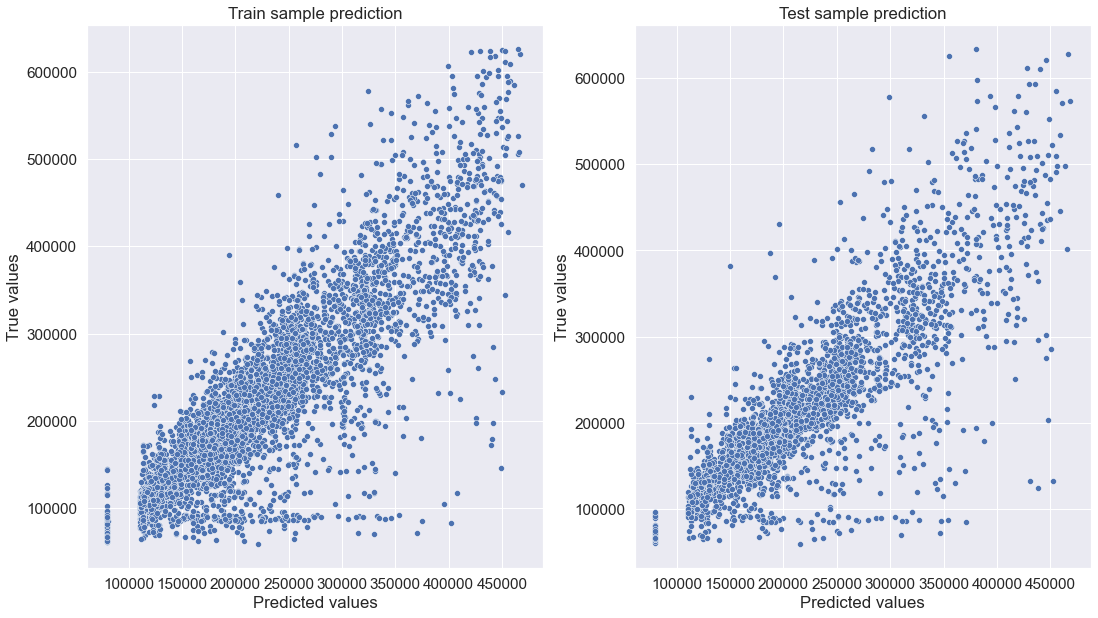

In [4029]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

Перекрестная проверка

In [4030]:
cv_score = cross_val_score(
    rf_model,
    X.fillna(-9999),
    y, scoring='r2',
    cv=KFold(n_splits=5, shuffle=True, random_state=21)
)
cv_score

array([0.7110314 , 0.69540246, 0.70679737, 0.71019815, 0.70059015])

In [4031]:
cv_score.mean(), cv_score.std()

(0.7048039058182891, 0.00596651224891556)

In [4032]:
cv_score.mean() - cv_score.std(), cv_score.mean() + cv_score.std()

(0.6988373935693736, 0.7107704180672046)

Важность признаков

In [4033]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.381879
13,MedPriceByDistrict,0.360114
0,Rooms,0.149028
9,Social_3,0.022082
27,HouseYear_2000,0.014033
7,Social_1,0.013769
8,Social_2,0.012858
3,KitchenSquare,0.010290
10,Healthcare_1,0.008019
2,LifeSquare,0.006691


In [4034]:
rf_model.fit(X_train_cluster, y)

RandomForestRegressor(max_depth=8, min_samples_split=100, n_estimators=500,
                      n_jobs=-1, random_state=39)

In [4035]:
y_test_preds = rf_model.predict(X_test_cluster)

In [4036]:
X_test_cluster

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,Ecology_1,Social_1,Social_2,Social_3,...,HouseYear_2000,HouseYear_2010,HouseYear_2020,Shops_2_A,Shops_2_B,Eco2_Eco3_AB,Eco2_Eco3_BA,Eco2_Eco3_BB,clusters_3_1,clusters_3_2
0,0.0,-0.178578,-0.005637,0.000000,0.000,0.125,1.317971,-0.466667,-0.447996,-0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
1,0.0,0.611006,0.937676,-0.500000,0.000,-1.500,0.001993,-0.633333,-0.679498,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
2,-1.0,-0.071402,-0.782270,1.000000,-0.500,-1.000,-0.423410,0.166667,0.397846,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,0.0,0.765147,0.816459,0.500000,2.000,1.125,0.148477,-0.066667,-0.123963,0.2,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
4,-1.0,-0.274545,0.436537,-0.500000,1.375,0.500,-0.018335,-0.766667,-0.822179,-0.2,...,0.0,1.0,0.0,1.0,-1.0,0.0,0.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1.0,0.524258,0.766220,0.000000,-0.125,-0.500,-0.422457,0.366667,0.124845,-0.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
4996,-1.0,-0.573122,-0.522031,0.666667,0.750,0.500,-0.383427,-0.800000,-0.886633,-0.4,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
4997,1.0,0.960524,0.653967,0.500000,2.125,1.125,0.086314,1.633333,2.436518,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
4998,0.0,1.101612,1.472562,-0.500000,-0.250,0.000,-0.018335,-0.766667,-0.822179,-0.2,...,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,1,0


In [4037]:
y_test_preds.shape

(5000,)

In [4038]:
y_2 = np.concatenate( [ y, y_test_preds] , axis = 0)
y_2.shape

(15000,)

In [4039]:
X_train_2 = np.concatenate( [ X_train_cluster, X_test_cluster] , axis = 0)
X_train_2.shape

(15000, 37)

In [4040]:
y_test_preds2 = rf_model.fit(X_train_2, y_2)

y_train_preds2 = rf_model.predict(X_train_2)

Train R2:	0.807


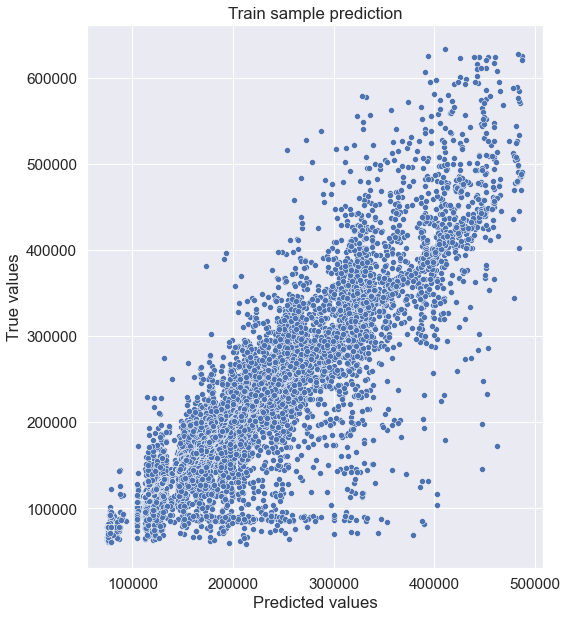

In [4041]:
print("Train R2:\t" + str(round(r2(y_2, y_train_preds2), 3)))

plt.figure(figsize=(18,10))
plt.subplot(121)
sns.scatterplot(x=y_train_preds2, y=y_2)
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Train sample prediction')
    
plt.show()

In [4042]:
test_id = test_df["Id"]
pred_df = pd.DataFrame()
pred_df["Id"] = test_id
pred_df["Price"] = y_test_preds

In [4043]:
pred_df

,Id,Price
0,725,160260.644200
1,15856,231390.883712
2,5480,293300.806406
3,15664,298570.631028
4,14275,128801.944589
...,...,...
4995,8180,258776.360017
4996,4695,145442.015449
4997,5783,317831.255005
4998,4780,183022.748863


In [4044]:
assert pred_df2.shape[0] == 5000, f"Real pred-shape = {pred_df.shape[0]}, Expected pred-shape = 5000"

No handles with labels found to put in legend.


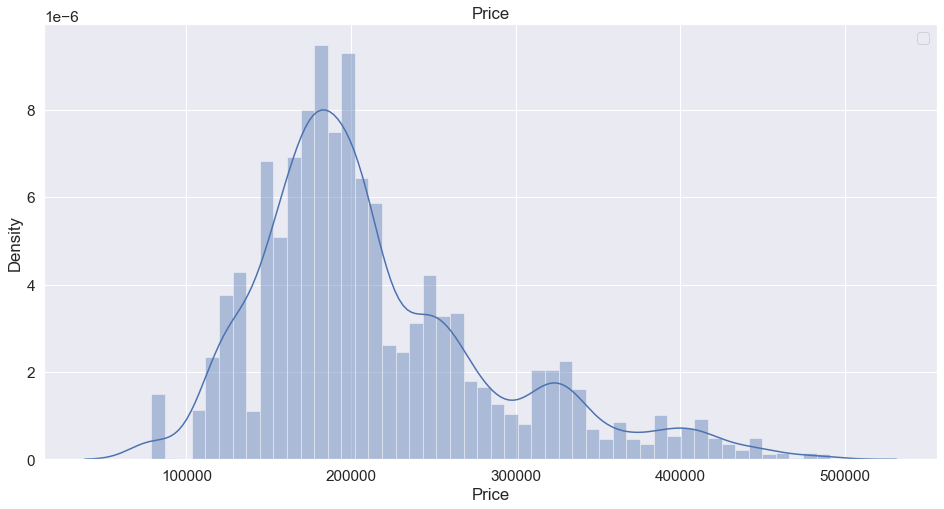

In [4045]:
plt.figure(figsize = (16, 8))

sns.distplot(pred_df.Price, bins=50)

y = np.linspace(0, 0.000005, 10)

plt.title('Price')
plt.legend()
plt.show()

In [4046]:
test_id = test_df["Id"]
pred_df2 = pd.DataFrame()
pred_df2["Id"] = test_id
pred_df2["Price"] = y_train_preds2[10000:]

In [4047]:
pred_df2

,Id,Price
0,725,163700.667063
1,15856,230854.756007
2,5480,290375.102752
3,15664,305009.712022
4,14275,129199.529095
...,...,...
4995,8180,264520.235741
4996,4695,147286.062132
4997,5783,320699.543596
4998,4780,181660.185065


Train R2:	0.747


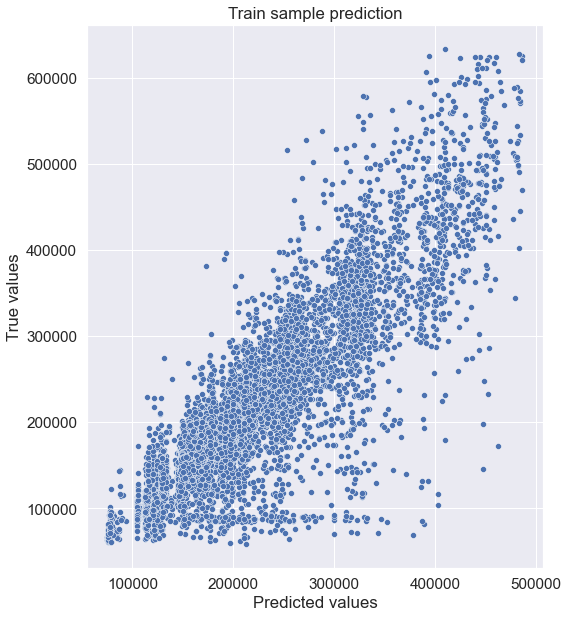

In [4048]:
print("Train R2:\t" + str(round(r2(y_2[:10000], y_train_preds2[:10000]), 3)))

plt.figure(figsize=(18,10))
plt.subplot(121)
sns.scatterplot(x=y_train_preds2[:10000], y=y_2[:10000])
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Train sample prediction')
    
plt.show()

No handles with labels found to put in legend.


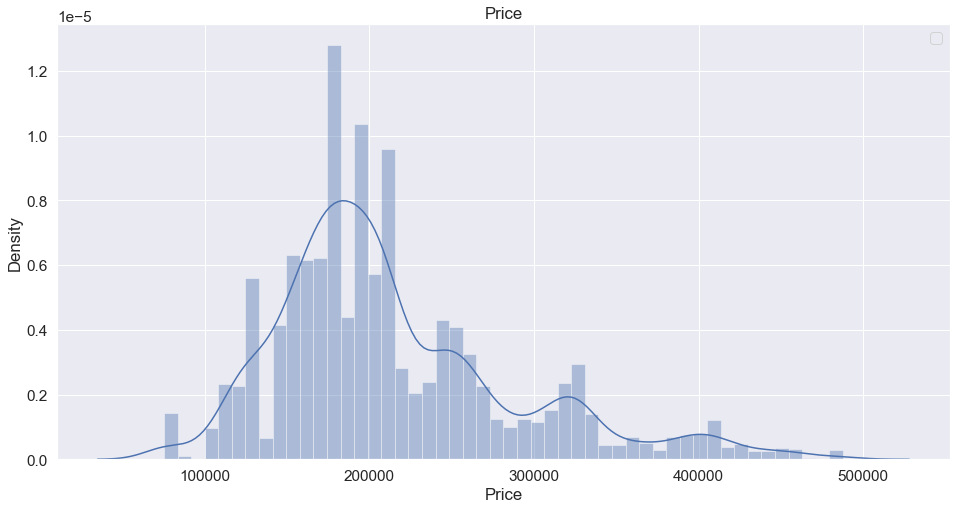

In [4049]:
plt.figure(figsize = (16, 8))

sns.distplot(pred_df2.Price, bins=50)

y = np.linspace(0, 0.000005, 10)

plt.title('Price')
plt.legend()
plt.show()

In [4050]:
r2(pred_df2.Price, pred_df.Price)

0.9967026882248382

In [4051]:
pred_df2.to_csv("D:/ASShubin_predictions", index=False)

In [4052]:
pred_df = pd.read_csv("D:/ASShubin_predictions")
pred_df.head(n=2)

,Id,Price
0,725,163700.667063
1,15856,230854.756007
